In [1]:
#2021_05_17 Core Francisco Park
#This code is not made for speed

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def smoothstep(x):
    """
    This is the b-spline interpolating from 0-1, i.e. smooth step function
    """
    return 3*x**2-2*x**3

def rand(coord_in,v_seed):
    """
    This generate a random number from the pixel coordinates
    arbitrary constant const=100, there is no reason this constant cannot be a parameter,
    but same goes for all symbolic 'parameters', so why not just leave this here....
    """
    const=100
    return np.remainder(np.cos(coord_in@v_seed)*const,1)

def perlin_noise(coord_in,v_seed):
    """
    vec_in contains the input coordinates
    """
    loc=np.floor(coord_in)
    vec_r=np.remainder(coord_in,1)
    A_00=rand(loc+np.array([0,0]),v_seed)
    A_01=rand(loc+np.array([1,0]),v_seed)
    A_10=rand(loc+np.array([0,1]),v_seed)
    A_11=rand(loc+np.array([1,1]),v_seed)
    #this gets the 2d interpolating weights
    w=smoothstep(vec_r)
    #This interpolates the 4 corners of value A_00,A_01,A_10,A_11
    res=A_00*(1-w[...,0])+A_01*w[...,0]+(A_10 - A_00)* w[...,1] * (1.0 - w[...,0]) +(A_11 - A_01) * w[...,0] * w[...,1]
    return res

def fbm(coord_in,num_octaves,v_seed):
    """
    One Generation sequence is a fractional brownian motion,
    similar to Gaussian noise but with non-sin/cos functions and less modes
    """
    res = np.zeros(coord_in.shape[:-1])
    Amp=1
    for i in range(num_octaves):
        #sample a rotation matrix
        theta=np.random.random()*2*np.pi
        c,s=np.cos(theta),np.sin(theta)
        rot=np.array([c,s,-s,c]).reshape(2,2)
        
        coord_in=coord_in@rot
        
        #add the perlin noise filter at this scale
        res += Amp*perlin_noise(coord_in,v_seed)
        
        #scale get smaller (coordinates gets bigger with fixed function)
        coord_in=coord_in * 3.0
        #mode amplitude diminishes, these two controls Pk
        Amp *= 0.3
    return res

def get_field(coord_in,s=None,s_xy=None,num_octaves=None,num_octaves_xy=None,vs=None,vs_xy=None):
    """
    Get a doubly stacked fbm noise
    Parameters are randomly sampled if not given
    s: scale of the final fbm sampling
    s_xy: scale of x,y deformations
    num_octaves:number of octaves of the final fbm sampling
    num_octaves_xy:number of octaves of x,y deformations
    vs: random vector length for the final fbm sampling
    vs_xy: random vector length for x,y deformations
    """
    if s is None:
        s=np.random.random()*5
    if s_xy is None:
        s_xy=np.random.random()*5
    if num_octaves is None:
        num_octaves=np.random.choice(np.arange(4,6))
    if num_octaves_xy is None:
        num_octaves_xy=np.random.choice(np.arange(4,6))
    if vs is None:
        vs=np.random.random()*2
    if vs_xy is None:
        vs_xy=np.random.random()*2
        
        
    v_seeds=np.random.normal(loc=0,scale=1,size=(2,2))
    v_seedsmag=np.linalg.norm(v_seeds,axis=1)
    v_seeds/=v_seedsmag[:,None]
    
    v_seed=vs*v_seeds[0] #random oriented vector of length vs
    v_seed_xy=vs_xy*v_seeds[1] #random oriented vector of length vs_xy

    q = np.stack([fbm(coord_in*s_xy,num_octaves_xy,v_seed_xy),fbm(coord_in*s_xy,num_octaves_xy,v_seed_xy)],axis=2)
    return fbm(coord_in*s+q,num_octaves,v_seed)

In [4]:
arr=np.arange(256)/256 #0~1
coord=np.stack(np.meshgrid(arr,arr,indexing="ij"),axis=-1)
coord.shape

(256, 256, 2)

In [5]:
N_fields=16
fields=[]
for i in range(N_fields):
    print("\r Generating: "+str(i+1)+"/"+str(N_fields),end="")
    field=get_field(coord)
    fields.append(field)
fields=np.stack(fields,axis=0)
fields.shape

 Generating: 16/16

(16, 256, 256)

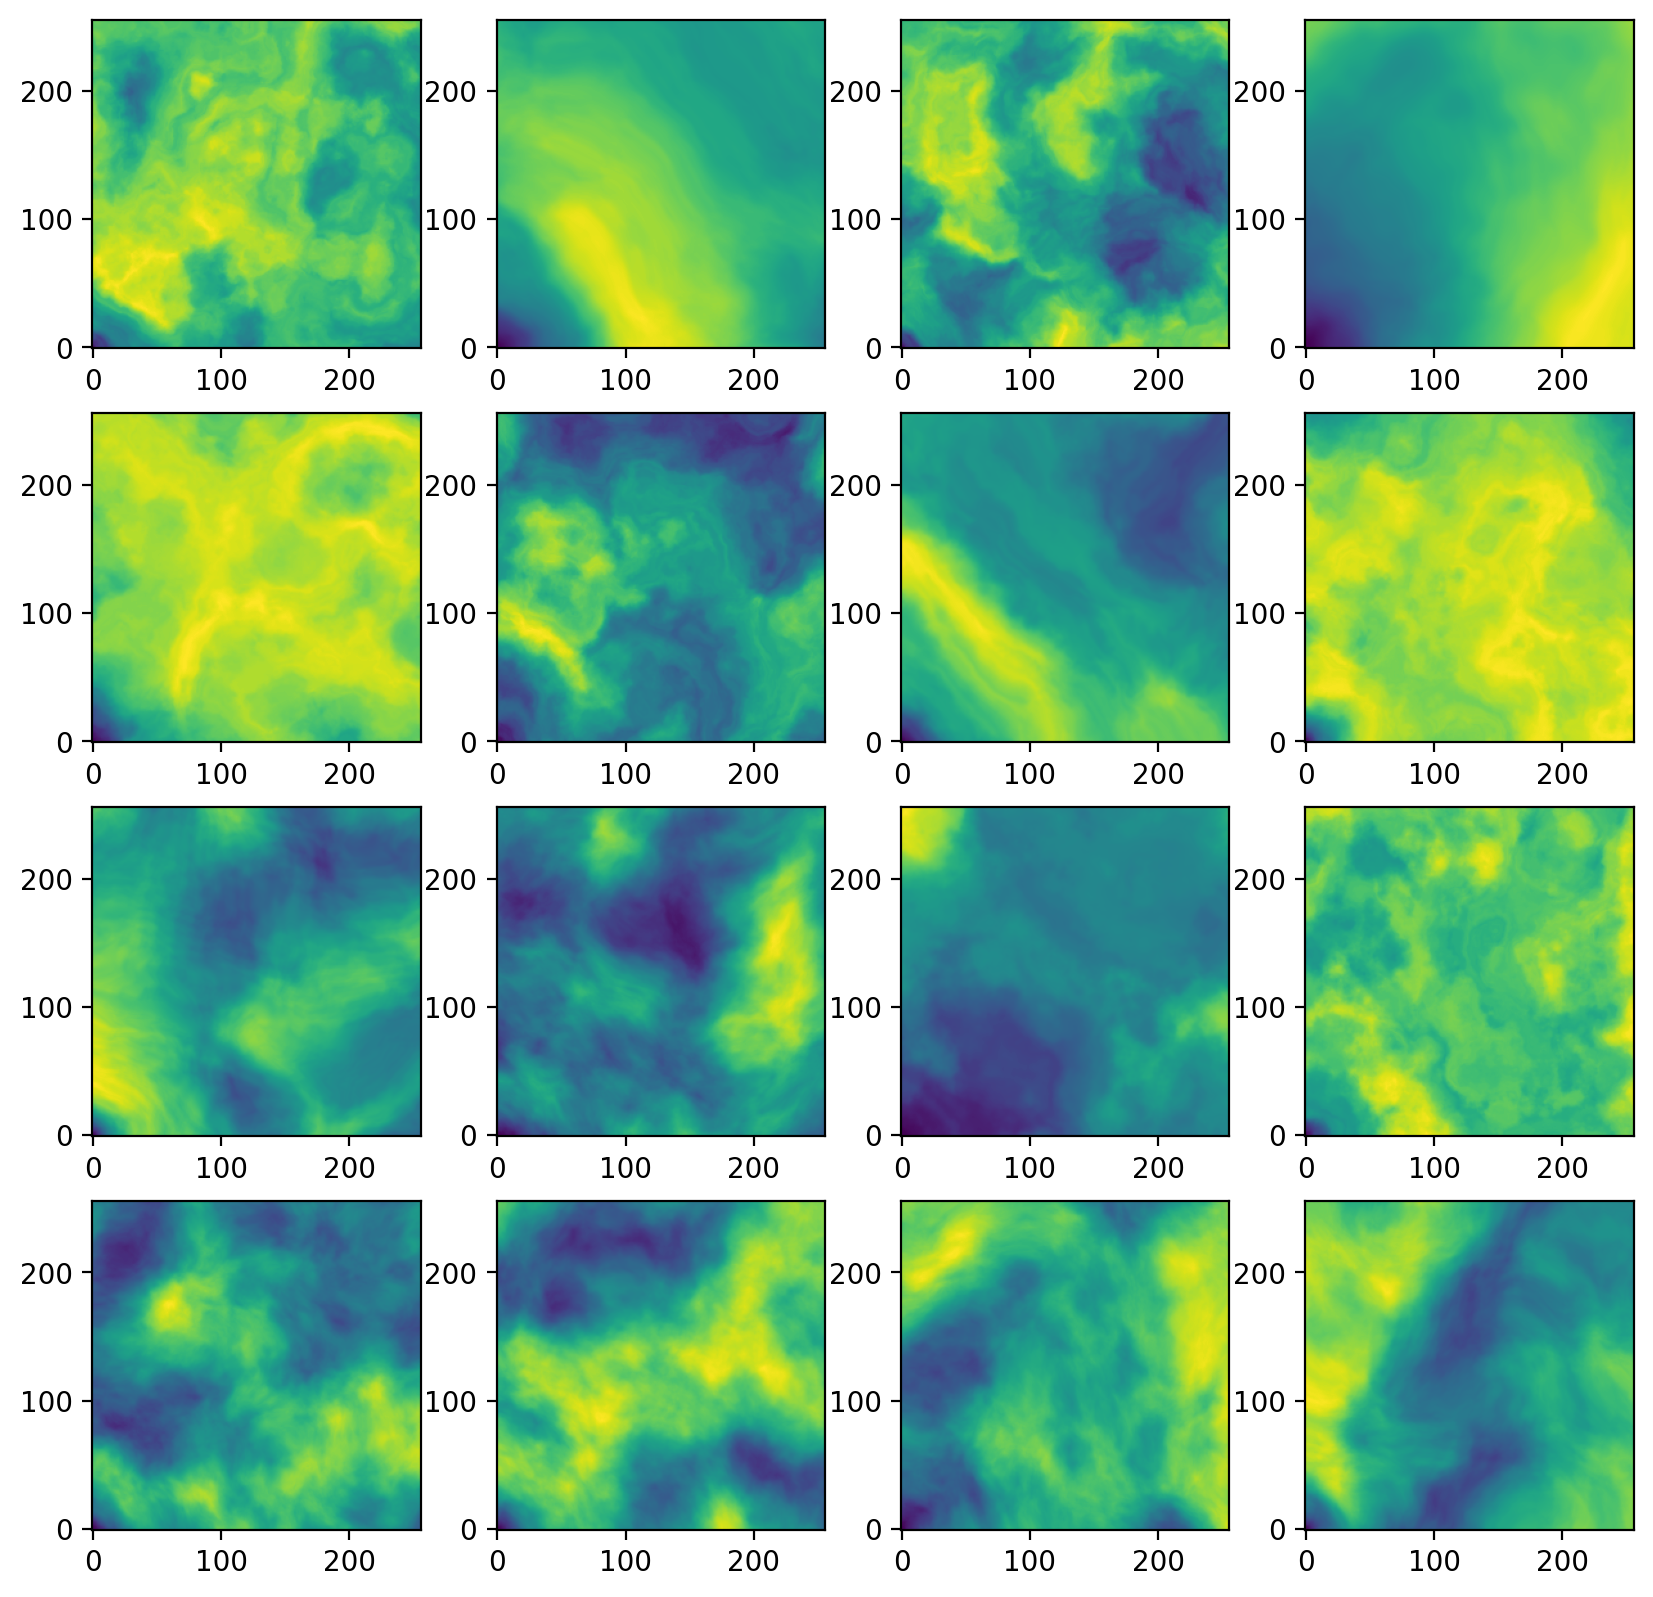

In [6]:
fig=plt.figure(figsize=(10,10),dpi=200)
inds=np.random.choice(N_fields,16,replace=False)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(fields[inds[i]].T,origin="lower")
#plt.savefig("Noises")